# Hepatic clearance model
Simple example model for coupling to sinusoidal and PKPD model structure.
Detoxification of substance `S` via hepatic transformation to `P`.

In [3]:
%matplotlib inline
from __future__ import print_function, division
import tellurium as te
from matplotlib import pyplot as plt
import clearance

Load model and simulation to steady state.

The time unit of the model is seconds and steady state from the initial concentrations is reached within a few secons.

['time', '[S_ext]', '[S]', '[P]', '[P_ext]']


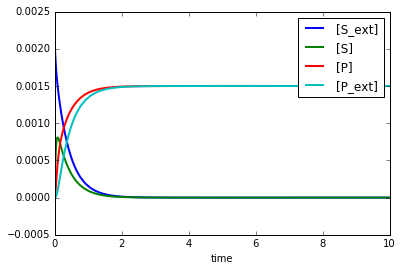

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

In [6]:
# load SBML
r = te.loads(clearance.sbml_cell)
r.integrator.absolute_tolerance = 1E-20
r.integrator.variable_step_size = True

# print(r.getAntimony(current=False))
r.resetToOrigin()
s = r.simulate(0, 10)
print(r.selections)
r.plot(s);

Same simulation, but now with a different external substrate `S` concentration.

['time', '[S_ext]', '[S]', '[P]', '[P_ext]']


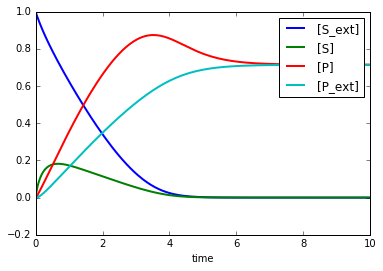

In [9]:
r.resetToOrigin()
r['init([S_ext])'] = 1.0  # [mM]
s = r.simulate(0, 10)
print(r.selections)
r.plot(s);

It takes a few seconds to clear the external volume from the substrate `S` and convert it into product `P`.

So how large is the external volume compared to the internal volume?

In [13]:
import pprint
d = dict(zip(r.getCompartmentIds(), r.getCompartmentVolumes() ))
pprint.pprint(d)

{'c': 2.3500000000000003e-15,
 'e': 5.8750000000000002e-15,
 'h': 5.8750000000000002e-15,
 'pm': 6.2500000000000001e-10}


## Time dependent challenge
Challenging the model with different external concentrations.

The external model has a fixed volume without any boundary conditions so that the model runs into a steady state.

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

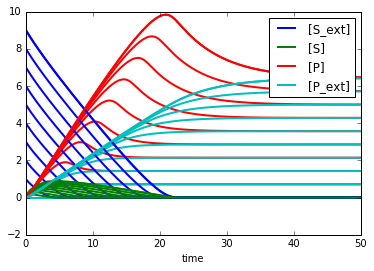

In [17]:
# give a time dependent challenge via composition of models
r.resetToOrigin()
for k in range(10):
    r.reset()
    r['init([S_ext])'] = k
    s = r.simulate(0, 50)
    r.plot(s, show=False, loc=False)
r.plot(s, show=False)

Internal and external concentrations reach equilibrium.

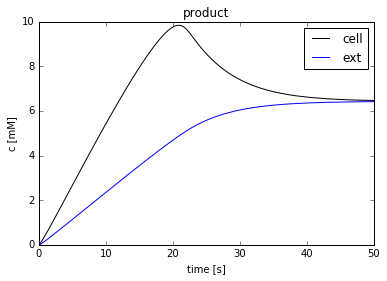

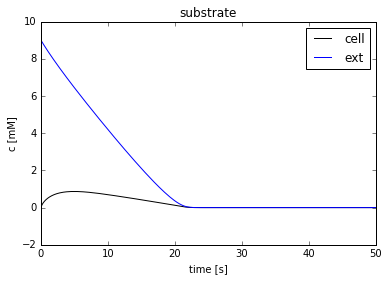

In [18]:
for key, name in {'P': 'product', 
                  'S': 'substrate'}.iteritems():
    plt.plot(s['time'], s['[{}]'.format(key)], color='black', label='cell')
    plt.plot(s['time'], s['[{}_ext]'.format(key)], color='blue', label='ext')
    plt.title(name)
    plt.xlabel('time [s]')
    plt.ylabel('c [mM]')
    
    plt.legend()
    plt.show()


## Parameter variation
Varying of paramters to check model

In [20]:
import multiscale.simulate.roadrunner_tools as rt

# Uset the filepath from the database
r = rt.MyRunner(clearance.sbml_cell)
r.timeCourseSelections = ['time'] + ['[{}]'.format(s) for s in r.model.getFloatingSpeciesIds()]
r.set_integrator_settings()

print(r.timeCourseSelections)

Time<__init__> SBML compile: 0.031476020813 [s]
['time', '[S_ext]', '[S]', '[P]', '[P_ext]']


In [21]:
# These are the parameters to vary
parameter_ids = r.model.getGlobalParameterIds()
sorted(parameter_ids)

['A_m',
 'PT_Vmax',
 'PT_k_P',
 'PT_keq',
 'S2P_Vmax',
 'S2P_k_S',
 'ST_Vmax',
 'ST_k_S',
 'ST_keq',
 'Vol_c',
 'Vol_e',
 'Vol_h',
 'f_cl',
 'f_cyto',
 'f_met',
 'f_tissue',
 'x_cell',
 'y_cell']

Time<simulate> : 0.00350117683411 [s]
Time<simulate> : 0.00355195999146 [s]
Time<simulate> : 0.00357604026794 [s]
Time<simulate> : 0.00346899032593 [s]
Time<simulate> : 0.00355792045593 [s]
Time<simulate> : 0.00346112251282 [s]
Time<simulate> : 0.00373792648315 [s]
Time<simulate> : 0.00344705581665 [s]
Time<simulate> : 0.00352120399475 [s]
Time<simulate> : 0.00354909896851 [s]
Time<simulate> : 0.00372195243835 [s]
Time<simulate> : 0.00361204147339 [s]
Time<simulate> : 0.00375699996948 [s]
Time<simulate> : 0.00356888771057 [s]
Time<simulate> : 0.00349903106689 [s]
Time<simulate> : 0.00351595878601 [s]
Time<simulate> : 0.00368213653564 [s]
RuntimeError CVODE integration for pid: f_cl = 0.9*p(0)
could not set value for f_cl, it is defined by an assignment rule, can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData*, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, int, const int*, const double*)
Time<simulate> : 0.00363111495

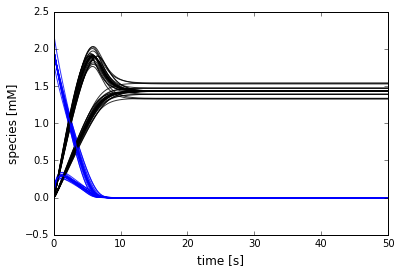

In [22]:
# single parameter variation
plt_fontsize=12
for factor in [0.9, 1.1]:
    for pid in parameter_ids:
        r.resetToOrigin()
        r['[S_ext]'] = 2.0  # [mM]
        try:
            r['{}'.format(pid)] = factor * r['{}'.format(pid)]
            data = r.simulate(0,50)
            plt.plot(data['time'], data['[P]'], '-', color='black', alpha=0.8)
            plt.plot(data['time'], data['[P_ext]'], '-', color='black', alpha=0.8)
            plt.plot(data['time'], data['[S]'], '-', color='blue', alpha=0.8)
            plt.plot(data['time'], data['[S_ext]'], '-', color='blue', alpha=0.8)
        except RuntimeError as detail:
            print("RuntimeError CVODE integration for pid: {} = {}*p(0)\n{}".format(pid, factor, detail))
            
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize);

# Clearance per volume
How much substance (amount) is cleared per time. 

It is possible to get the estimates of clearance per volume liver tissue from the single cell models and compare to the tissue models. In the above time courses the 

['time', '[S_ext]', '[S]', '[P]', '[P_ext]', 'ST', 'S2P', 'PT']
amount: 1.175e-14 mole
Time<simulate> : 0.00356698036194 [s]
['e', 'h', 'c', 'pm']
[  5.87500000e-15   5.87500000e-15   2.35000000e-15   6.25000000e-10]
['ST', 'S2P', 'PT']
[ -3.49258755e-29  -4.32510492e-29   2.10540681e-24]
           time,      [S_ext],          [S],         [P],     [P_ext],           ST,          S2P,           PT
 [[           0,            2,            0,           0,           0,  3.46905e-15,            0,            0],
  [ 3.83236e-10,            2,  5.65729e-10, 2.82283e-18, 6.70722e-27,  3.46905e-15,  1.73096e-23, -1.02822e-31],
  [ 3.83274e-06,            2,  5.65754e-06, 2.82263e-10, 6.70658e-15,  3.46903e-15,  1.73094e-19, -1.02812e-23],
  [ 4.21563e-05,      1.99998,  6.22064e-05, 2.18945e-08, 3.49668e-12,  3.46883e-15,  1.90214e-18, -7.97378e-22],
  [ 8.04798e-05,      1.99995,  0.000118727,  6.8519e-08, 1.55112e-11,  3.46864e-15,  3.62839e-18, -2.49524e-21],
  [ 0.000118803,      1.9999

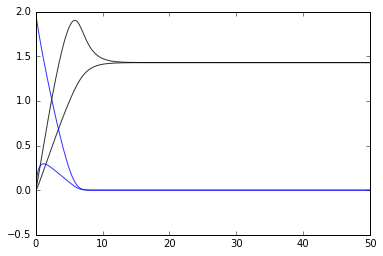

In [23]:
r.timeCourseSelections = ['time'] + ['[{}]'.format(sid) for sid in r.getFloatingSpeciesIds()] + r.getReactionIds()
print(r.timeCourseSelections)

r.resetToOrigin()
r['[S_ext]'] = 2.0  # [mM=mole/m3]
print('amount:', r['S_ext'], 'mole')

data = r.simulate(0, 50)
plt.plot(data['time'], data['[P]'], '-', color='black', alpha=0.8)
plt.plot(data['time'], data['[P_ext]'], '-', color='black', alpha=0.8)
plt.plot(data['time'], data['[S]'], '-', color='blue', alpha=0.8)
plt.plot(data['time'], data['[S_ext]'], '-', color='blue', alpha=0.8)

print(r.getCompartmentIds())
print(r.getCompartmentVolumes())

print(r.getReactionIds())
print(r.getReactionRates())

print(data)

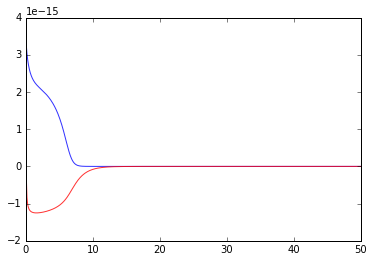

In [26]:
plt.plot(data['time'], data['ST'], '-', color='blue', alpha=0.8)
plt.plot(data['time'], data['PT'], '-', color='red', alpha=0.8)

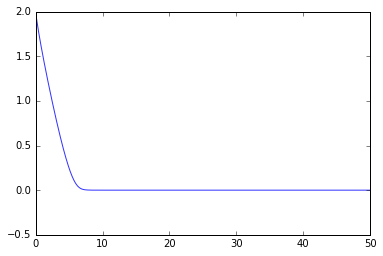

In [18]:
plt.plot(data['time'], data['[S_ext]'], '-', color='blue', alpha=0.8)

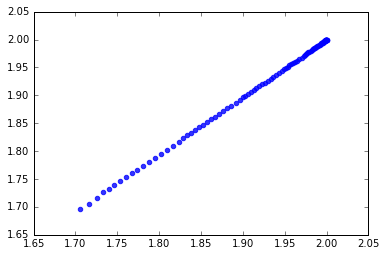

In [25]:
plt.scatter(data['[S_ext]'][1:100], data['[S_ext]'][2:101], color='blue', alpha=0.8)

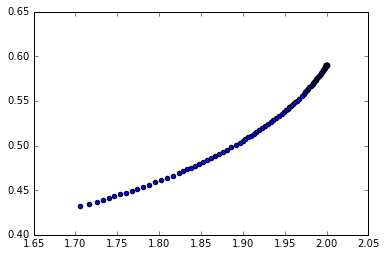

In [24]:
x1 = data['[S_ext]'][1:100]
x2 = data['[S_ext]'][2:101]
t1 = data['time'][1:100]
t2 = data['time'][2:101]

plt.scatter(x1, (x2-x1)/(t1-t2))